In [1]:
from dctkit.dec import cochain as C
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.mesh.util import generate_line_mesh, build_complex_from_mesh
from dctkit.math.opt import optctrl as oc
import matplotlib.pyplot as plt
from deap import gp
from alpine.gp import gpsymbreg as gps
from dctkit import config
import dctkit
import numpy as np
import ray
import math
import yaml
from typing import Tuple, Callable, List
import numpy.typing as npt

In [2]:
# choose precision and whether to use GPU or CPU
# needed for context of the plots at the end of the evolution
config()

def eval_MSE_sol(residual: Callable, X: npt.NDArray, y: npt.NDArray,
             S: SimplicialComplex, u_0: C.CochainP0) -> float:

    num_nodes = X.shape[1]

    # need to call config again before using JAX in energy evaluations to make sure that
    # the current worker has initialized JAX
    config()

    # objective: squared norm of the residual of the equation + penalty on Dirichlet 
    # boundary condition on the first node
    def obj(x, y):
        penalty = 100.*x[0]**2
        u = C.CochainP0(S, x)
        f = C.CochainP0(S, y)
        r = residual(u, f)
        total_energy = C.inner_product(r, r) + penalty
        return total_energy

    prb = oc.OptimizationProblem(dim=num_nodes, state_dim=num_nodes, objfun=obj)

    total_err = 0.

    best_sols = []

    for i, vec_y in enumerate(y):
        # set additional arguments of the objective function (apart from the vector of unknowns)
        args = {'y': vec_y}
        prb.set_obj_args(args)

        # minimize the objective
        x = prb.solve(x0=u_0.coeffs, ftol_abs=1e-12, ftol_rel=1e-12, maxeval=1000)

        if (prb.last_opt_result == 1 or prb.last_opt_result == 3
                or prb.last_opt_result == 4):

            current_err = np.linalg.norm(x-X[i, :])**2
        else:
            current_err = math.nan

        if math.isnan(current_err):
            total_err = 1e5
            break

        total_err += current_err

        best_sols.append(x)

    total_err *= 1/X.shape[0]

    return total_err, best_sols

In [3]:
@ray.remote
def predict(individual: Callable, indlen: int, X: npt.NDArray, y: npt.NDArray,
            S: SimplicialComplex, u_0: C.CochainP0, penalty: dict) -> List[npt.NDArray]:

    _, best_sols = eval_MSE_sol(individual, X, y, S, u_0)

    return best_sols

In [4]:
@ray.remote
def fitness(individual: Callable, indlen: int, X: npt.NDArray, y: npt.NDArray,
                 S: SimplicialComplex, u_0: C.CochainP0, penalty: dict) -> Tuple[float, ]:

    total_err, _ = eval_MSE_sol(individual, X, y, S, u_0)

    # add penalty on length of the tree to promote simpler solutions
    objval = total_err + penalty["reg_param"]*indlen

    return objval,

In [7]:
def stgp_poisson():
    with open("ex1.yaml") as config_file:
        config_file_data = yaml.safe_load(config_file)

    # generate mesh and dataset
    mesh, _ = generate_line_mesh(num_nodes=11, L=1.)
    S = build_complex_from_mesh(mesh)
    S.get_hodge_star()
    x = S.node_coords 
    num_nodes = S.num_nodes

    # generate training and test datasets
    # exact solution = x² 
    u = C.CochainP0(S, np.array(x[:,0]**2, dtype=dctkit.float_dtype))
    # compute source term such that u solves the discrete Poisson equation 
    # Delta u + f = 0, where Delta is the discrete Laplace-de Rham operator
    f = C.laplacian(u)
    f.coeffs *= -1.
    X_train = np.array([u.coeffs],dtype=dctkit.float_dtype)
    y_train = np.array([f.coeffs], dtype=dctkit.float_dtype)

    # initial guess for the unknown of the Poisson problem (cochain of nodals values)
    u_0_vec = np.zeros(num_nodes, dtype=dctkit.float_dtype)
    u_0 = C.CochainP0(S, u_0_vec)

    # define primitive set for the residual of the discrete Poisson equation
    pset = gp.PrimitiveSetTyped("RESIDUAL", [C.CochainP0, C.CochainP0], C.CochainP0)

    # rename arguments of the residual
    pset.renameArguments(ARG0="u")
    pset.renameArguments(ARG1="f")

    penalty = config_file_data["gp"]["penalty"]
    common_params = {'S': S, 'u_0': u_0, 'penalty': penalty}

    gpsr = gps.GPSymbolicRegressor(pset=pset, fitness=fitness.remote,
                                    predict_func=predict.remote, common_data=common_params,
                                    feature_extractors=[len],
                                    print_log=True, 
                                    config_file_data=config_file_data)



    param_names = ('X', 'y')

    gpsr.fit(X_train, y_train, param_names)

    u_best = gpsr.predict(X_train, y_train, param_names)

    ray.shutdown()
    plt.figure()
    plt.plot(x[:,0], u.coeffs)
    plt.plot(x[:,0], np.ravel(u_best), "ro")
    plt.show()


2024-02-15 13:44:41,696	INFO worker.py:1636 -- Started a local Ray instance.


> MODEL TRAINING/SELECTION STARTED
Generating initial population...
DONE.
 -= START OF EVOLUTION =- 
Evaluating initial population...


(fitness pid=36444) Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
(fitness pid=36444) 2024-02-15 13:44:44.346031: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


(fitness pid=36444) Metal device set to: Apple M2 Pro
(fitness pid=36444) 
(fitness pid=36444) systemMemory: 32.00 GB
(fitness pid=36444) maxCacheSize: 10.67 GB
(fitness pid=36444) 
DONE.
   	     	           fitness            	             size             
   	     	------------------------------	------------------------------
gen	evals	min   	avg   	max   	std   	min	avg 	max	std   
1  	100  	2.8333	2.9527	3.2333	0.1457	3  	4.23	9  	1.5288
The best individual of this generation is: delP1(cobP0(f))
2  	100  	2.8333	2.8333	2.8333	0     	3  	3   	3  	0     
The best individual of this generation is: delP1(cobP0(f))
3  	100  	2.8333	2.8333	2.8333	0     	3  	3   	3  	0     
The best individual of this generation is: delP1(cobP0(f))
4  	100  	2.6399	2.8314	2.8333	0.0192	3  	3.04	7  	0.398 
The best individual of this generation is: AddCP0(MFP0(u, InnP0(f, f)), f)
5  	100  	2.6399	2.8314	2.8333	0.0192	3  	3.04	7  	0.398 
The best individual of this generation is: AddCP0(MFP0(u, InnP0(f, f

(fitness pid=36445) Platform 'METAL' is experimental and not all JAX functionality may be correctly supported! [repeated 9x across cluster]
(fitness pid=36445) 2024-02-15 13:44:44.348671: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported! [repeated 9x across cluster]


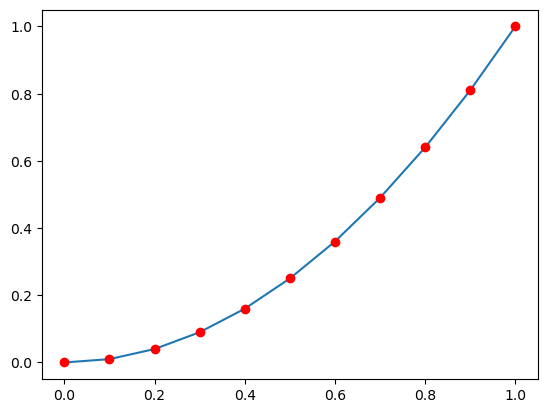

In [8]:
stgp_poisson()
